# Example script of imaging using L-BFGS-B optimizer

SMILI have several imaging functions, but the most general one is a static imaging (no dynamical/no multi-frequency) function using L-BFGS-B.
This notebook describes a tutorial and introducition to SMILI's imaging function with L-BFGS-B.

In this notebook, we wil use a [VLBA 43 GHz data set](3C273DEC16.UVP) observed by [the Boston University Blazar Group](https://www.bu.edu/blazars/VLBAproject.html).

In [50]:
%matplotlib inline
from pylab import *
from smili import uvdata,imdata,imaging,util

First, you need to load the uvfits data into **uvdata.UVFITS** object.

In [51]:
uvfits = uvdata.UVFITS("./3C273DEC16.UVP")

Filename: ./3C273DEC16.UVP
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 GroupsHDU      155   (3, 4, 1, 4, 1, 1)   float32   1913 Groups  7 Parameters
  1  AIPS NX       1 BinTableHDU     31   8R x 7C   [1E, 1E, 1J, 1J, 1J, 1J, 1J]   
  2  AIPS FQ       1 BinTableHDU     29   1R x 6C   [1J, 4D, 4E, 4E, 4J, 32A]   
  3  AIPS AN       1 BinTableHDU     72   10R x 14C   [8A, 3D, 0D, 1J, 1J, 1E, 1E, 4E, 1A, 1E, 8E, 1A, 1E, 8E]   

Loading HDUs in the input UVFITS files.
  Primary HDU was loaded.
  AIPS FQ Table was loaded.
  Subarray 1 was found in an AIPS AN table

Checking loaded HDUs.
  1 Subarray settings are found.
  No AIPS SU tables were found.
    Assuming that this is a single source UVFITS file.

Reading FQ Tables
  Frequency Setup ID: 1
    IF Freq setups (Hz):
         if_freq_offset  ch_bandwidth  if_bandwidth  sideband
      0             0.0    64000000.0    64000000.0         1
      1      80000000.0    64000000.0    64000000.0         

As you can see the above log, this data set has full Stokes parameters. A simple way to make Stokes I image is computing Stokes I visibilities using UVFITS.select_stokes method.

In [58]:
uvfits_I = uvfits.select_stokes(stokes="I")

Stokes I data will be calculated from input RR and LL data


For imaging, SMILI use two dimensional data tables using classes inheriting **pandas.DataFrame**.

In [59]:
# Create a table of full complex visibilities
vistable = uvfits_I.make_vistable()

# Create a table of bi-spectra (default: only independent closure quantities)
bstable = vistable.make_bstable()
#bstable = vistable.make_bstable(redundant=[["AA", "AP"],["SM","JC","SR"]]) # if you have redundant sites and want to omit trivial closures
#bstable = vistable.make_bstable(dependent=True)

# Create a table of closure amplitudes
catable = vistable.make_catable()
#catable = vistable.make_catable(redundant=[["AA", "AP"],["SM","JC","SR"]]) # if you have redundant sites and want to omit trivial closures
#catable = vistable.make_catable(dependent=True)

  2%|▏         | 124/7647 [00:00<00:06, 1231.82it/s]

(1/5) Sort data
(2/5) Tagging data


 11%|█         | 27/248 [00:00<00:01, 211.73it/s]

  Number of Tags: 248
(3/5) Checking Baseline Combinations


  0%|          | 1/248 [00:00<00:31,  7.90it/s]

  Detect 25 combinations for Closure Phases
(4/5) Forming Closure Phases


  2%|▏         | 139/7647 [00:00<00:05, 1376.65it/s]

(5/5) Creating BSTable object
(1/5) Sort data
(2/5) Tagging data


  0%|          | 0/248 [00:00<?, ?it/s]

  Number of Tags: 248
(3/5) Checking Baseline Combinations


  0%|          | 1/248 [00:00<00:39,  6.19it/s]

  Detect 25 combinations for Closure Amplitudes
(4/5) Forming Closure Amplitudes


100%|██████████| 248/248 [00:34<00:00,  7.14it/s]


(5/5) Creating CATable object


You can save these tables with .to_csv() methods in a similar way to pandas.DataFrame

In [ ]:
vistable.to_csv("vistable.csv")
bstable.to_csv("bstable.csv")
catable.to_csv("catable.csv")

You can read these tables with **uvdata.read_XXtable** functions. You probably don't need to recompute closure quanties onece they are formulated, so this save & load process can save your time for full closure imaging.

In [5]:
vistable = uvdata.read_vistable("vistable.csv")
bstable = uvdata.read_bstable("bstable.csv")
catable = uvdata.read_catable("catable.csv")

In [ ]:
util.matplotlibrc(width=500, height=300)
vistable.radplot(datatype="imag")

In [ ]:
util.matplotlibrc(width=500, height=300)
vistable.tplot()

In [ ]:
util.matplotlibrc(width=500, height=300)
vistable.baseline_list() # List of baselines
vistable.station_dic(id2name=False) # dictionary connecting ID number and name
vistable.station_list() # List of stations
vistable.vplot(baseline=["BR","FD"], axis1="utc", axis2="vreal")

## 2. Full Closure Imaging

Here, we would try a simple imaging with full closure quantities and also error-increased amplitude data sets.
Full closure imaging is non-convex optimization, so therefore the resultant image will be affected by a choise of the initial image. In particular, you need non-zero (not empty image) for closure imaging, since closure imaging do not have sensitivities in the absolute position and needs a reference for a relative position.

Here, we can start from a circular Gaussian, of which beam size is corresponding to the minor beam size of the synthesized beam.
You can estimate beam size parameters from vistable.

In [6]:
beamprm = vistable.fit_beam(angunit="mas")
print(beamprm)

{u'minsize': 0.11969941024814679, u'pa': -15.60577507084539, u'majsize': 0.6946287189501326, u'angunit': 'mas'}


For starting imaging, we need to define the image FOV, pixel size. SMILI will do it by setting the initial image.

(<matplotlib.image.AxesImage at 0x1c2d945d10>,
 <matplotlib.colorbar.Colorbar at 0x1c2d87f2d0>)

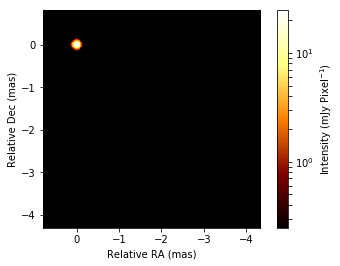

In [7]:
# This command can create an empty image. The final option uvfitsfile is optional, and can read header informations from uvfits file.
initimage = imdata.IMFITS(dx=0.02, nx=256, ny=256, nxref=40, nyref=216, angunit="mas", uvfitsfile="3C273DEC16.UVP")

# set beam
initimage.set_beam(**beamprm)

# add a Gaussian
beamprm["majsize"] = beamprm["minsize"]
initimage = initimage.add_gauss(totalflux=1, **beamprm) # this can add a circular or elliptical gaussian to the image

# show imagee
initimage.imshow(scale="log", dyrange=100, fluxunit="mJy", saunit="pixel", colorbar=True)

In interferometric imaging, limiting imaging region genrally works as a really nice prior if we have a reliable prior information for the source structure. SMILI has a function to set such a region with **imdata.IMRegion** object. To make a region table more flexiblly, please have a look at the instruction of IMRegion.

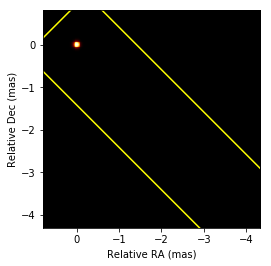

In [8]:
imregion = imdata.IMRegion()
imregion = imregion.add_box(xc=-2.0,yc=-2.0,width=7.0,height=2.0,angle=-45,angunit="mas")

imregion.plot(angunit="mas",color="yellow")
initimage.imshow()

Before starting imaging, let's make a table for visibility amplitudes. Since they could have residual gain errors, let's add additional errors for residual errrors. We can copy tables for full complex visibilities and add potential systematic errors.

In [9]:
syserr = 0.01
amptable = vistable.copy()
amptable = amptable.add_error(error=amptable["amp"]*0.2)

Then, now is the time to make the first image! The simplest imaging function is imaging.lbfgs.imaging.

In [10]:
imprm = {}
imprm["amptable"]=amptable # use amplitudes
imprm["bstable"]=bstable # use closure phases
imprm["catable"]=catable # use closure amplitudes
imprm["lambl1"]=1
imprm["lambtsv"]=0.1
# Total flux regularization
imprm["fluxconst"]=True
imprm["totalflux"]=12
# Cent-of-mass regularization
imprm["lambcom"]=1.0
imprm["compower"]=5.0 # the power of the centroid. 1 gives the regularization using the exact center of the mass. The higher value gives regularization using the region close to the peak of the image.
# iteration number
imprm["niter"]=1000 
# imaging window
imprm["imregion"]=imregion 

In [11]:
outimage = imaging.lbfgs.imaging(initimage,**imprm)

Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: set to 12


You can check howthe image is.

(<matplotlib.image.AxesImage at 0x1c2ddf4890>,
 <matplotlib.colorbar.Colorbar at 0x1c2df48e10>)

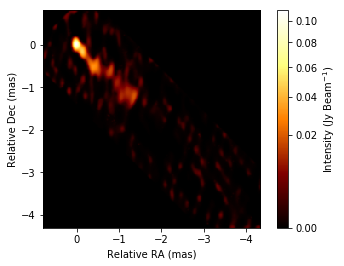

In [13]:
outimage.convolve_gauss(scale=0.25, **beamprm).imshow(scale="gamma",dyrange=100,saunit="beam",colorbar=True)

In [14]:
outimage.to_fits("3C273_image.fits")

You can also see the statistical quantities (chisquares, reduced chisquares) with imaging.lbfgs.statistics

In [15]:
imaging.lbfgs.statistics(outimage, **imprm)

Imaging Window: Specified. Images will be calcurated on specified pixels.
Imaging Window: Specified. Images will be calcurated on specified pixels.


OrderedDict([('cost', 2.1360701791818633),
             ('chisq', 6419.326044676482),
             ('rchisq', 0.9705663811122591),
             ('isfcv', False),
             ('isamp', True),
             ('iscp', True),
             ('isca', True),
             ('chisqfcv', 0.0),
             ('chisqamp', 630.5967708658529),
             ('chisqcp', 3574.6063971267276),
             ('chisqca', 2214.122876683901),
             ('rchisqfcv', 0.0),
             ('rchisqamp', 0.2379610456097558),
             ('rchisqcp', 1.7643664349095398),
             ('rchisqca', 1.1424782645427765),
             ('lambl1', 1),
             ('lambl1_sim', 0.08333333333333333),
             ('l1', 12.511645447600353),
             ('l1cost', 1.0426371206333627),
             ('lambtv', 0.0),
             ('lambtv_sim', 0.0),
             ('tv', 5.040902667636085),
             ('tvcost', 0.0),
             ('lambtsv', 0.1),
             ('lambtsv_sim', 11.377777777777778),
             ('tsv', 0.0107

You can make a summary plot.

/Users/akiyama/anaconda/lib/python2.7/site-packages/smili-0.0.1-py2.7.egg/smili/imaging/lbfgs.py:586: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/akiyama/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/akiyama/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/akiyama/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/akiyama/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/akiyama/anaconda/lib/python2.7/site-package

Imaging Window: Specified. Images will be calcurated on specified pixels.
Imaging Window: Specified. Images will be calcurated on specified pixels.


/Users/akiyama/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.


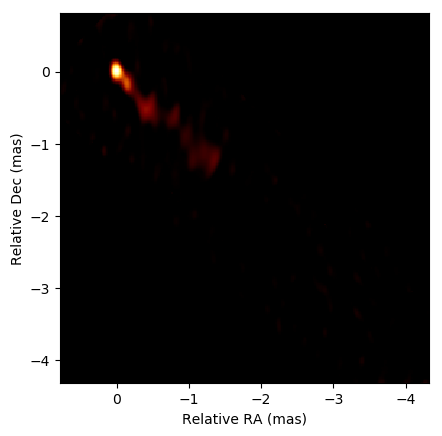

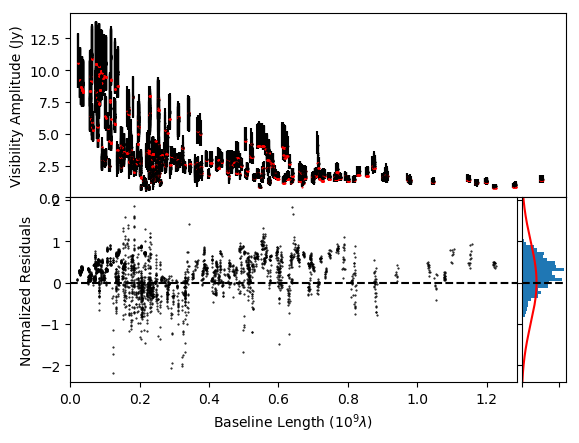

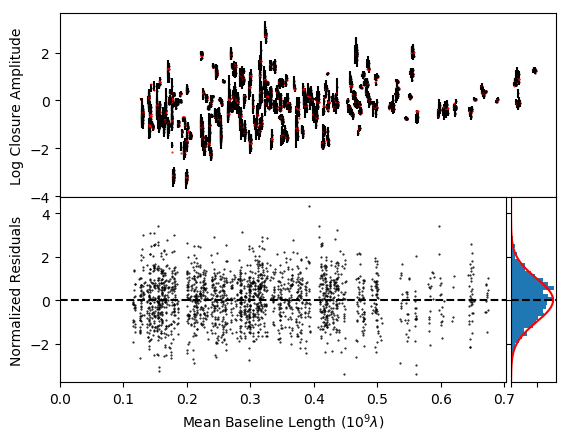

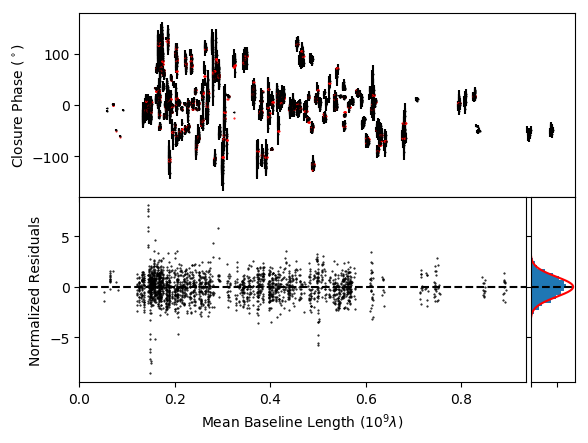

/Users/akiyama/anaconda/lib/python2.7/site-packages/smili-0.0.1-py2.7.egg/smili/imaging/lbfgs.py:889: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'agg' by the following code:
  File "/Users/akiyama/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/akiyama/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/akiyama/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/akiyama/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/akiyama/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486,

Imaging Window: Specified. Images will be calcurated on specified pixels.
Imaging Window: Specified. Images will be calcurated on specified pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.


In [16]:
imaging.lbfgs.plots(outimage,imprm)
imaging.lbfgs.plots(outimage,imprm,filename="out1.pdf")

You can also make such a plot by yourself. **xxtable.eval_image** or **xxtable.residual_image** can compute model or residual quantities of each data set.

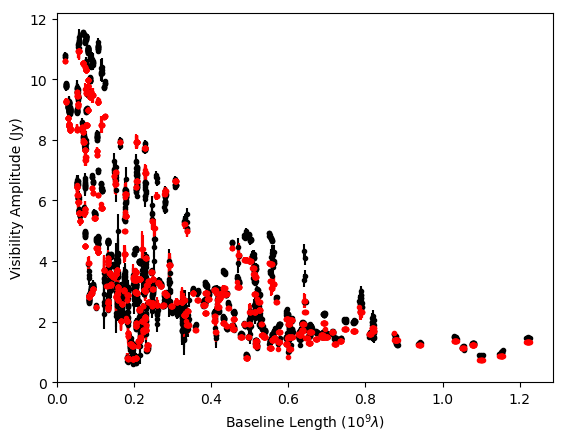

In [17]:
modelvis = vistable.eval_image(outimage)
vistable.radplot(color="black")
modelvis.radplot(color="red")

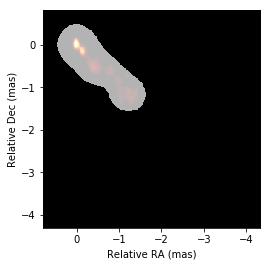

In [57]:
regimage = outimage.convolve_gauss(majsize=0.5, angunit="mas").hard_threshold(0.10)
regimage.data[np.where(regimage.data>0)] = 1
regimage.imshow()
outimage.imshow(alpha=0.3)

In [54]:
imprm = {}
imprm["amptable"]=amptable # use amplitudes
imprm["bstable"]=bstable # use closure phases
imprm["catable"]=catable # use closure amplitudes
imprm["lambl1"]=0.5
imprm["lambtsv"]=0.5
# Cent-of-mass regularization
imprm["lambcom"]=1.0
imprm["compower"]=5.0 # the power of the centroid. 1 gives the regularization using the exact center of the mass. The higher value gives regularization using the region close to the peak of the image.
# iteration number
imprm["niter"]=1000 
# imaging window
imprm["imregion"]=imregion 

In [55]:
for i in xrange(5):
    if i == 0:
        imprm["reweight"]=False
    else:
        imprm["reweight"]=True
    imprm["imregion"] = regimage
    outimage = outimage.hard_threshold(0.03)
    outimage = imaging.lbfgs.imaging(outimage,**imprm)

Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: disabled.
Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: disabled.
Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: disabled.
Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: disabled.
Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: disabled.


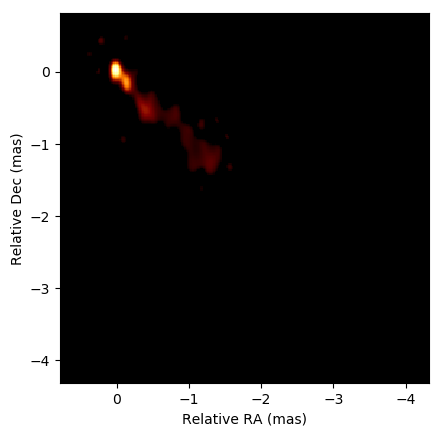

In [22]:
outimage.imshow()

Imaging Window: Not Specified. We calcurate the image on all the pixels.


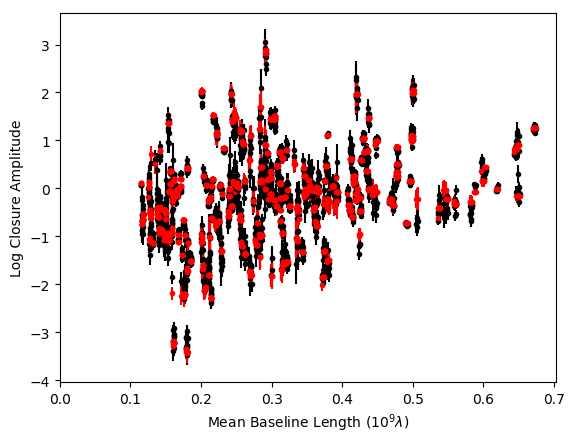

In [26]:
modelvis = catable.eval_image(outimage)
catable.radplot(color="black")
modelvis.radplot(color="red")

In [42]:
uvfits = uvdata.UVFITS("./3C273DEC16.UVP").avspc()
cltable = uvfits.selfcal(outimage)
#cltable = cltable.clear_amp() # for phase selfcal
#cltable = cltable.clear_phase()  # for amplitude selfcal
uvfits2 = uvfits.apply_cltable(cltable)

Filename: ./3C273DEC16.UVP
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 GroupsHDU      155   (3, 4, 1, 4, 1, 1)   float32   1913 Groups  7 Parameters
  1  AIPS NX       1 BinTableHDU     31   8R x 7C   [1E, 1E, 1J, 1J, 1J, 1J, 1J]   
  2  AIPS FQ       1 BinTableHDU     29   1R x 6C   [1J, 4D, 4E, 4E, 4J, 32A]   
  3  AIPS AN       1 BinTableHDU     72   10R x 14C   [8A, 3D, 0D, 1J, 1J, 1E, 1E, 4E, 1A, 1E, 8E, 1A, 1E, 8E]   


0it [00:00, ?it/s]


Loading HDUs in the input UVFITS files.
  Primary HDU was loaded.
  AIPS FQ Table was loaded.
  Subarray 1 was found in an AIPS AN table

Checking loaded HDUs.
  1 Subarray settings are found.
  No AIPS SU tables were found.
    Assuming that this is a single source UVFITS file.

Reading FQ Tables
  Frequency Setup ID: 1
    IF Freq setups (Hz):
         if_freq_offset  ch_bandwidth  if_bandwidth  sideband
      0             0.0    64000000.0    64000000.0         1
      1      80000000.0    64000000.0    64000000.0         1
      2     144000000.0    64000000.0    64000000.0         1
      3     208000000.0    64000000.0    64000000.0         1
    Note: Central Frequency of ch=i at IF=j (where i,j=1,2,3...)
       freq(i,j) = reffreq + (i-1) * ch_bandwidth(j) * sideband + if_freq_offset(j)

Reading AN Tables
  Sub Array ID: 1
    Frequency Setup ID: 1
    Reference Frequency: 43007500000 Hz
    Reference Date: 2016-12-
    AN Table Contents:
         id      name             x  

124it [00:01, 115.86it/s]


In [45]:
vtable = uvfits.select_stokes("I").make_vistable()

Stokes I data will be calculated from input RR and LL data


In [47]:
imprm = {}
imprm["amptable"]=vistable # use amplitudes
imprm["bstable"]=bstable # use closure phases
imprm["catable"]=catable # use closure amplitudes
imprm["lambl1"]=0.5
imprm["lambtsv"]=0.5
# Total flux regularization
imprm["fluxconst"]=True
imprm["totalflux"]=12
# Cent-of-mass regularization
imprm["lambcom"]=1.0
imprm["compower"]=5.0 # the power of the centroid. 1 gives the regularization using the exact center of the mass. The higher value gives regularization using the region close to the peak of the image.
# iteration number
imprm["niter"]=1000 
# imaging window
imprm["imregion"]=imregion 

In [48]:
for i in xrange(5):
    if i == 0:
        imprm["reweight"]=False
    else:
        imprm["reweight"]=True
    imprm["imregion"] = regimage
    outimage = outimage.hard_threshold(0.03)
    if i == 0:
        outimage = imaging.lbfgs.imaging(initimage,**imprm)
    else:
        outimage = imaging.lbfgs.imaging(outimage,**imprm)

Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: set to 12
Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: set to 12
Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: set to 12
Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: set to 12
Imaging Window: Specified. Images will be solved on specified pixels.
Total Flux Constraint: set to 12


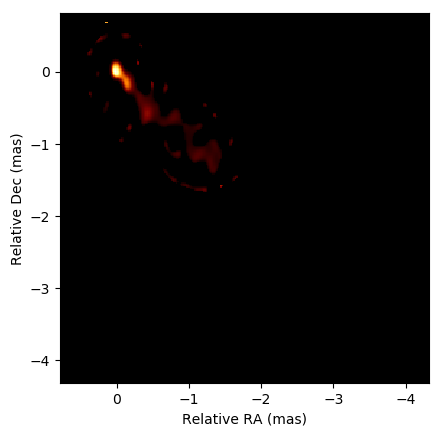

In [49]:
outimage.imshow()